In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon, box

from libpysal import weights
import matplotlib.pyplot as plt
import networkx as nx

fips_df = pd.read_csv("state_and_county_fips_master.csv")
fips_df = fips_df[fips_df["state"].isin(["MD", "DC", "VA"])]
fips_df["code"] = fips_df["fips"].apply(lambda a: str(a)[-3:])
dc_codes = fips_df[fips_df["name"].isin(["District of Columbia"])]["code"]
md_codes = fips_df[fips_df["state"] == "MD"][fips_df["name"].isin(["Prince George's County", "Montgomery County"])]["code"]
va_codes = fips_df[fips_df["state"] == "VA"][fips_df["name"].isin(["Arlington County", "Alexandria city", "Fairfax County", "Fairfax city", "Falls Church city", "Loudoun County", "Prince William County", "Manassas city", "Manassas Park city"])]["code"]

C:\Users\srjnk\AppData\Local\Temp\ipykernel_17160\1049747349.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  md_codes = fips_df[fips_df["state"] == "MD"][fips_df["name"].isin(["Prince George's County", "Montgomery County"])]["code"]
C:\Users\srjnk\AppData\Local\Temp\ipykernel_17160\1049747349.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  va_codes = fips_df[fips_df["state"] == "VA"][fips_df["name"].isin(["Arlington County", "Alexandria city", "Fairfax County", "Fairfax city", "Falls Church city", "Loudoun County", "Prince William County", "Manassas city", "Manassas Park city"])]["code"]


In [2]:
def get_points(df, extremities, layers=6):
    ids = []
    if layers <= 0:
        return ids
    if df.shape[0] < 2:
        return ids
    df_sorted = df.sort_values("point_likelihood",ascending=False)
    top_point = df_sorted.iloc[1]
    ids.append(top_point.SID)
    ex_bl = [extremities[0], extremities[1], top_point["INTPTLON20"], top_point["INTPTLAT20"]]
    df_bl = df.iloc[df.sindex.query(box(*ex_bl))] # bottom left
    ex_br = [top_point["INTPTLON20"], extremities[1], extremities[2], top_point["INTPTLAT20"]]
    df_br = df.iloc[df.sindex.query(box(*ex_br))] # bottom right
    ex_tl = [extremities[0], top_point["INTPTLAT20"], top_point["INTPTLON20"], extremities[3]]
    df_tl = df.iloc[df.sindex.query(box(*ex_tl))] # top left
    ex_tr = [top_point["INTPTLON20"], top_point["INTPTLAT20"], extremities[2], extremities[3]]
    df_tr = df.iloc[df.sindex.query(box(*ex_tr))] # top right
    ids += get_points(df_bl, ex_bl, layers-1) + get_points(df_br, ex_br, layers-1) + get_points(df_tl, ex_tl, layers-1) + get_points(df_tr, ex_tr, layers-1)
    return ids

In [3]:
md_df = gpd.read_file("md/tl_2023_24_tabblock20.shp")
md_df = md_df[md_df["COUNTYFP20"].isin(md_codes.to_list())]
va_df = gpd.read_file("va/tl_2023_51_tabblock20.shp")
va_df = va_df[va_df["COUNTYFP20"].isin(va_codes.to_list())] 
dc_df = gpd.read_file("dc/tl_2023_11_tabblock20.shp")
df = pd.concat([md_df, va_df, dc_df])
df.index = np.arange(df.shape[0])

In [4]:
df.to_crs("EPSG:4326",inplace=True)
df["SID"] = df.index
df["INTPTLON20"] = df["INTPTLON20"].apply(lambda a: float(a))
df["INTPTLAT20"] = df["INTPTLAT20"].apply(lambda a: float(a))
# add NEIGHBORS column
df["NEIGHBORS"] = None
extremities = [df["INTPTLON20"].min(), df["INTPTLAT20"].min(), df["INTPTLON20"].max(), df["INTPTLAT20"].max()]
df["transit_potential"] = np.log(df['POP20']/(df['ALAND20'] + df['AWATER20'])*1000 + 1)

for index, country in df.iterrows():   
    break
    # get 'not disjoint' countries
    neighbors = df[~df.geometry.disjoint(country.geometry)].SID.tolist()

    # remove own name of the country from the list
    neighbors = [ name for name in neighbors if country.SID != name ]

    # add names of neighbors as NEIGHBORS value
    df.at[index, "NEIGHBORS"] = neighbors
    
#df["point_likelihood"] = [df.loc[i]["transit_potential"] - (df.loc[df.NEIGHBORS.loc[i]]["transit_potential"].mean()) for i in range(1, df.shape[0] + 1)]

In [5]:
df["point_likelihood"] = df["transit_potential"]
l = list(set(get_points(df, extremities)))
points = gpd.GeoDataFrame(df[df['SID'].isin(l)])


In [6]:
#points["geometry"] = points.apply(lambda a: Point(a["INTPTLAT20"],a["INTPTLAT20"]),axis=1)
#points
#np.hstack([points.iloc[1].geometry.centroid.xy])
#np.vstack([points.iloc[[1,2]].geometry.centroid.x,points.iloc[[1,2]].geometry.centroid.y]).T

C:\Users\srjnk\AppData\Local\Temp\ipykernel_17160\200588442.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_points = gpd.GeoDataFrame(geometry=points.centroid)
C:\Users\srjnk\AppData\Local\Temp\ipykernel_17160\200588442.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  knn3 = weights.Gabriel.from_dataframe(df_points)
c:\Users\srjnk\Documents\metro_project\venv\Lib\site-packages\libpysal\weights\gabriel.py:145: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  return cls(point_array, ids=ids, **kwargs)
c:\Users\srjnk\Documents\metro_project\venv\Lib\site-packages\libpysal\weights\weights.py:1484: UserW

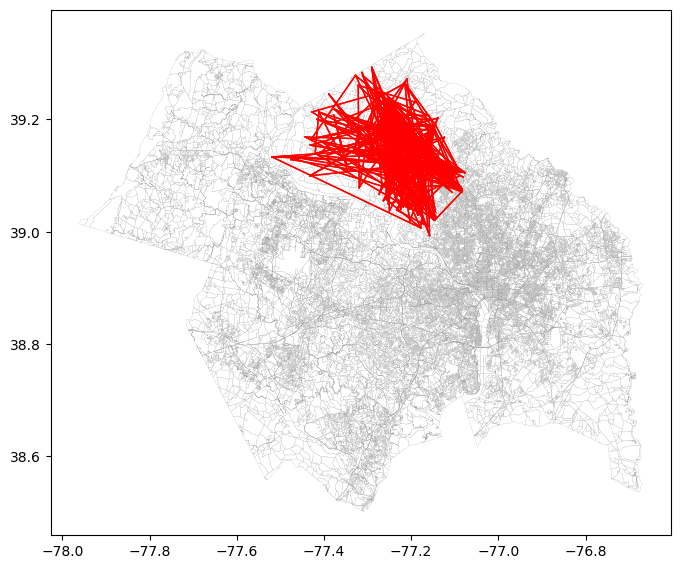

In [7]:
df_points = gpd.GeoDataFrame(geometry=points.centroid)
knn3 = weights.Gabriel.from_dataframe(df_points)
#knn_graph = knn3.to_networkx()
#coordinates = np.column_stack((df_points.geometry.x, df_points.geometry.y))
#positions = dict(zip(knn_graph.nodes, coordinates))

#nx.draw(knn_graph, positions, node_size=5, node_color="b")
ax = df.plot(edgecolor='grey', facecolor='w', figsize=(8,8), linewidth=0.1)
f,ax = knn3.plot(df, ax=ax,
        edge_kws=dict(color='r', linewidth=1),
        node_kws=dict(marker=''))
#ax.set_axis_off()
#plt.savefig("network_map")

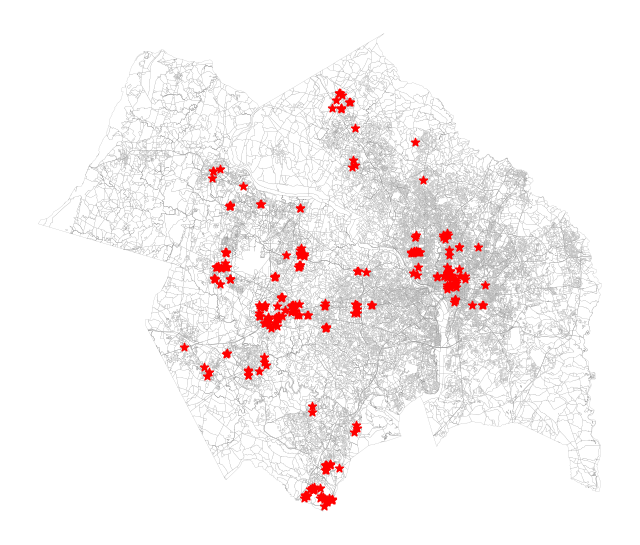

In [8]:
'''ax = df.plot(edgecolor='black', facecolor='w', figsize=(8,8), linewidth=0.1)
ax.set_axis_off()
plt.savefig("city_map")
plt.show()
ax = df.plot("transit_potential", edgecolor='black', facecolor='w', figsize=(8,8), linewidth=0.1)
ax.set_axis_off()
plt.savefig("transit_potential")
plt.show()
ax = df.plot("point_likelihood", edgecolor='black', facecolor='w', figsize=(8,8), linewidth=0.1)
ax.set_axis_off()
plt.savefig("point_likelihood")
plt.show()'''
ax = df.plot(edgecolor='grey', facecolor='w', figsize=(8,8), linewidth=0.1)
ax = df_points.plot(ax=ax, color='r', marker='*')
ax.set_axis_off()
#plt.savefig("stations")


In [9]:
df

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,GEOIDFQ20,NAME20,MTFCC20,UR20,UACE20,...,AWATER20,INTPTLAT20,INTPTLON20,HOUSING20,POP20,geometry,SID,NEIGHBORS,transit_potential,point_likelihood
0,24,031,701002,1010,240317010021010,1000000US240317010021010,Block1010,G5040,U,92242,...,0,39.059417,-77.175772,45,126,"POLYGON ((-77.17783 39.05929, -77.1778 39.0595...",0,None,1.138908,1.138908
1,24,031,700317,1070,240317003171070,1000000US240317003171070,Block1070,G5040,R,None,...,674537,39.188216,-77.283703,0,0,"POLYGON ((-77.29914 39.19383, -77.29857 39.194...",1,None,0.000000,0.000000
2,24,031,700713,1001,240317007131001,1000000US240317007131001,Block1001,G5040,U,92242,...,72362,39.162754,-77.199461,329,802,"POLYGON ((-77.20513 39.16644, -77.20497 39.166...",2,None,1.546955,1.546955
3,24,031,700317,1065,240317003171065,1000000US240317003171065,Block1065,G5040,R,None,...,0,39.183855,-77.308791,0,0,"POLYGON ((-77.31274 39.18391, -77.31268 39.184...",3,None,0.000000,0.000000
4,24,031,700839,3002,240317008393002,1000000US240317008393002,Block3002,G5040,U,92242,...,0,39.120667,-77.200374,0,0,"POLYGON ((-77.20636 39.11792, -77.20579 39.118...",4,None,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47563,11,001,009901,1009,110010099011009,1000000US110010099011009,Block1009,G5040,U,92242,...,0,38.874207,-76.961658,11,35,"POLYGON ((-76.96233 38.87401, -76.96233 38.874...",47563,None,1.497270,1.497270
47564,11,001,008701,2004,110010087012004,1000000US110010087012004,Block2004,G5040,U,92242,...,0,38.917828,-77.004298,43,107,"POLYGON ((-77.00509 38.91812, -77.00486 38.918...",47564,None,2.634755,2.634755
47565,11,001,000804,1011,110010008041011,1000000US110010008041011,Block1011,G5040,U,92242,...,0,38.924807,-77.092823,6,23,"POLYGON ((-77.09344 38.92454, -77.0934 38.9250...",47565,None,1.242989,1.242989
47566,11,001,000804,2009,110010008042009,1000000US110010008042009,Block2009,G5040,U,92242,...,0,38.915491,-77.097444,66,100,"POLYGON ((-77.10052 38.91899, -77.10045 38.918...",47566,None,0.839616,0.839616
